In [29]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib
import tifffile

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot
from typing import Any
from skimage import filters

from evaluation import get_dataset
# from utils.plotting import savefig

import sys
to_add = ".."
while to_add in sys.path:
    sys.path.remove(to_add)
sys.path.append(to_add)

# from datasets import TarFLCDataset
# from modules.transforms import SimCLRTransform
# from main import SimCLR
from model_builder import get_base_model

class SimCLR(torch.nn.Module):
    def __init__(self, backbone, cfg):
        super().__init__()
        self.backbone = backbone
        self.cfg = cfg

        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.projection_head = heads.SimCLRProjectionHead(
            input_dim=self.cfg.dim,
            hidden_dim=512,
            output_dim=128,
        )

    def forward(self, x):
        features = self.backbone(x)
        if features.dim() > 2:
            features = self.avg_pool(features)

        z = self.projection_head(features)
        return z

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="green-magenta",
    colors=["tab:green", "#ff00ff"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="gray-purple",
    colors=["#353535", "#aa87de"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

# Use a resnet backbone.
MODEL = "resnet18"
# MODEL = "resnet18_IMAGENET1K_V1"
# MODEL = "resnet50"
# MODEL = "resnet50_IMAGENET1K_V1"
# MODEL = "MICRA-Net"
# MODEL = "naive"
# MODEL = "ConvNeXt-tiny"
# MODEL = "ConvNeXt-tiny_IMAGENET1K_V1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False
transform = None

if MODEL == "resnet18":
    backbone, cfg = get_base_model("resnet18")
    model = SimCLR(backbone, cfg)
    
    checkpoint = torch.load("./data/SSL/baselines/resnet18_STED/result.pt", map_location="cpu")
    print(checkpoint.keys())
    ckpt = checkpoint.get("state_dict", None)    
    if ckpt is not None:
        ckpt = {key.replace("backbone.", ""): values for key, values in ckpt.items()}
        backbone.load_state_dict(ckpt, strict=False)
        
elif MODEL == "resnet50" : 
    backbone, cfg = get_backbone("resnet50")
    model = SimCLR(backbone, cfg)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet50/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
        
elif MODEL == "MICRA-Net":
    backbone, cfg = get_backbone("micranet")
    model = SimCLR(backbone, cfg)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
    
elif MODEL == "ConvNeXt-tiny":
    backbone, cfg = get_backbone("convnext-tiny")
    model = SimCLR(backbone, cfg)
    checkpoint = torch.load("./data/ssl/baselines/convnext/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
        
elif MODEL == "resnet18_IMAGENET1K_V1":
    backbone, cfg = get_backbone("resnet18")
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    transform.mean = [0.0695771782959453, 0.0695771782959453, 0.0695771782959453]
    transform.std = [0.12546228631005282, 0.12546228631005282, 0.12546228631005282]
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone, cfg)
    REQUIRES_3_CHANNELS = True
    
elif MODEL == "resnet50_IMAGENET1K_V1":
    backbone, cfg = get_backbone("resnet50")
    transform = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.transforms()
    transform.mean = [0.0695771782959453, 0.0695771782959453, 0.0695771782959453]
    transform.std = [0.12546228631005282, 0.12546228631005282, 0.12546228631005282]
    backbone = torchvision.models.resnet50(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone, cfg)
    REQUIRES_3_CHANNELS = True
    
elif MODEL == "ConvNeXt-tiny_IMAGENET1K_V1":
    backbone, cfg = get_backbone("convnext-tiny")
    transform = torchvision.models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms()
    transform.mean = [0.0695771782959453, 0.0695771782959453, 0.0695771782959453]
    transform.std = [0.12546228631005282, 0.12546228631005282, 0.12546228631005282]
    backbone = torchvision.models.convnext_tiny(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    
    model = SimCLR(backbone, cfg)
    REQUIRES_3_CHANNELS = True
elif MODEL == "naive": 
    backbone = get_backbone("naive")
    model = SimCLR(backbone)
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()
# print(model)
print("Model loaded")
print(DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])
Model loaded
cuda


/tmp/ipykernel_23981/2974026091.py:61: UserWarning: Overwriting the cmap 'nice-prism' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_23981/2974026091.py:62: UserWarning: Overwriting the cmap 'nice-prism_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_23981/2974026091.py:68: UserWarning: Overwriting the cmap 'green-magenta' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_23981/2974026091.py:69: UserWarning: Overwriting the cmap 'green-magenta_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_23981/2974026091.py:75: UserWarning: Overwriting the cmap 'gray-purple' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_23981/2974026091.py:76: UserWarning: Overwriting the cmap 'gray-purple_r' tha

In [22]:

DATASET = "optim"
dataset = get_dataset(DATASET, transform=transform, requires_3_channels=REQUIRES_3_CHANNELS)
print(dataset)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=16,
    shuffle=True,
    num_workers=1
)

Dataset(optim) -- length: 438
actin - 261
tubulin - 60
CaMKII_Neuron - 56
PSD95_Neuron - 61



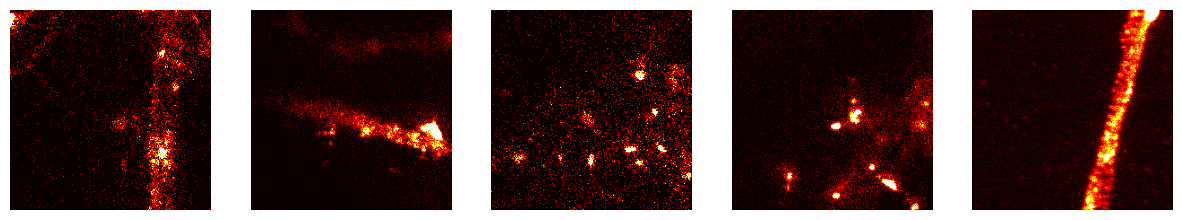

In [10]:
fig, axes = pyplot.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    random_idx = random.randint(0, len(dataset))
    img, info = dataset[random_idx]
    img = img.cpu().data.numpy()
    ax.imshow(img[0], vmin=numpy.quantile(img[0], 0.), vmax=numpy.quantile(img[0], 0.995), cmap="hot")
    ax.axis("off")
pyplot.show()

# KNN

In [26]:
out = defaultdict(list)
for x, label in tqdm(dataloader):
    
    x = x.to(DEVICE)
    features = model.backbone(x).flatten(start_dim=1)
    for key, values in label.items():
        if isinstance(values, torch.Tensor):
            out[key].extend(values.cpu().data.numpy().tolist())
        else:
            out[key].extend(values)
    out["features"].extend(features.cpu().data.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 53.08it/s]


Accuracy: 75.06
Accuracy (actin): 76.17
Accuracy (tubulin): 60.36
Accuracy (CaMKII_Neuron): 68.53
Accuracy (PSD95_Neuron): 91.65


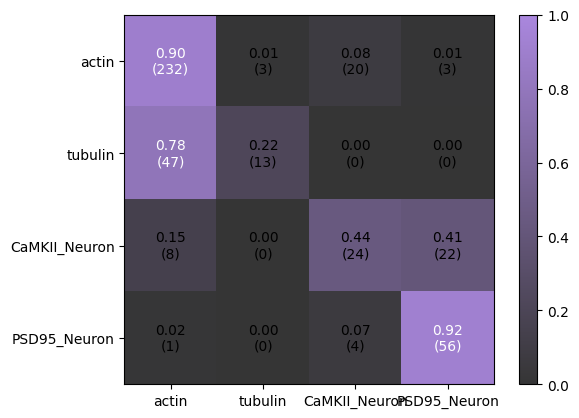

In [27]:
from sklearn.neighbors import NearestNeighbors
SHOW_MISSED = False

samples = numpy.array(out["features"])
labels = numpy.array(out["label"])
indices = numpy.array(out["dataset-idx"])

neigh = NearestNeighbors(n_neighbors=6, metric="minkowski", p=2)
neigh.fit(samples)

# 1st nn is itself
neighbors = neigh.kneighbors(samples, return_distance=False)[:, 1:]
associated_labels = labels[neighbors]

# accuracy = numpy.sum(associated_labels == labels[:, numpy.newaxis], axis=-1)
uniques = numpy.unique(labels)
confusion_matrix = numpy.zeros((len(uniques), len(uniques)))
for unique in uniques:
    mask = labels == unique
    for predicted_unique in uniques:
        votes = numpy.sum((associated_labels[mask] == predicted_unique).astype(int), axis=-1)
        confusion_matrix[unique, predicted_unique] += numpy.sum(votes >= 3)
        if SHOW_MISSED and (unique != predicted_unique) and (numpy.sum(votes >= 3) > 0):
            print(unique, predicted_unique)
            for idx, associated in zip(indices[mask][votes >= 3], associated_labels[mask][votes >= 3]):
                img, metadata = dataset[idx]
                img = img[0].cpu().data.numpy()
                
                fig, ax = pyplot.subplots(figsize=(3,3))
                ax.imshow(img, cmap="hot", vmin=numpy.quantile(img, 0), vmax=numpy.quantile(img, 0.995))
                ax.set_title(associated)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                pyplot.show()
                
def accuracy_per_class(confusion_matrix):
    diag = numpy.diag(confusion_matrix)
    confusion_matrices = {}
    for i in range(len(diag)):
        indices = numpy.setdiff1d(numpy.arange(len(diag)), [i])
        cm = numpy.zeros((2, 2))
        cm[0, 0] = diag[i]
        cm[0, 1] = numpy.sum(confusion_matrix[i, indices])
        cm[1, 1] = numpy.sum(diag[indices])
        cm[1, 0] = numpy.sum(confusion_matrix[indices, i])        
        confusion_matrices[i] = cm
    return confusion_matrices
                
accuracy = numpy.diag(confusion_matrix).sum() / numpy.sum(confusion_matrix)
print(f"Accuracy: {accuracy * 100:0.2f}")
confusion_matrices = accuracy_per_class(confusion_matrix)
for key, cm in confusion_matrices.items():
    tp, tn, fp, fn = cm[0, 0], cm[1, 1], cm[1, 0], cm[0, 1]
    balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    print(f"Accuracy ({dataset.classes[key]}): {balanced_accuracy * 100:0.2f}")

fig, ax = pyplot.subplots()
cm = confusion_matrix / numpy.sum(confusion_matrix, axis=-1)[:, numpy.newaxis]
im = ax.imshow(cm, vmin=0, vmax=1, cmap="gray-purple")
for j in range(cm.shape[-2]):
    for i in range(cm.shape[-1]):
        ax.annotate(
            f"{cm[j, i]:0.2f}\n({confusion_matrix[j, i]:0.0f})", (i, j), 
            horizontalalignment="center", verticalalignment="center",
            color="white" if cm[j, i] > 0.5 else "black"
        )
ax.set(
    xticks=uniques, yticks=uniques,
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)
pyplot.colorbar(im, ax=ax)
# savefig(fig, ax, f"./panels/{MODEL}/knn-classification-{DATASET}", save_white=True)
pyplot.show()


Accuracy: 55.74
Accuracy (Block): 72.99
Accuracy (0Mg): 56.25
Accuracy (KCl): 64.20
Accuracy (Glu-Gly): 69.33


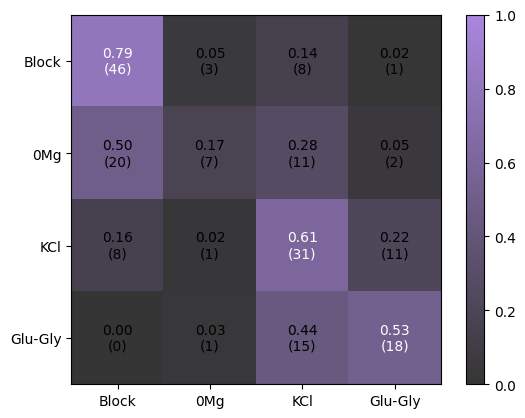

In [141]:
if "path" in out:
    paths = numpy.array(out["path"])

    per_path_samples, per_path_labels, experiments = [], [], []
    for unique in numpy.unique(paths):
        masked_features = numpy.array(out["features"])[paths == unique]
        masked_labels = numpy.array(out["label"])[paths == unique].tolist()

        mean = numpy.mean(masked_features, axis=0)
        std = numpy.std(masked_features, axis=0)
#         per_path_samples.append(numpy.concatenate((mean, std)))
        per_path_samples.append(mean)        
        per_path_labels.append(max(masked_labels, key=masked_labels.count))
        experiments.append(unique.split("EXP")[-1][:3])

    per_path_samples = numpy.array(per_path_samples)
    per_path_labels = numpy.array(per_path_labels)
    
    samples = per_path_samples
    labels = per_path_labels

    neigh = NearestNeighbors(n_neighbors=6, metric="minkowski", p=2)
    neigh.fit(samples)

    # 1st nn is itself
    neighbors = neigh.kneighbors(samples, return_distance=False)[:, 1:]
    associated_labels = labels[neighbors]

    # accuracy = numpy.sum(associated_labels == labels[:, numpy.newaxis], axis=-1)
    uniques = numpy.unique(labels)
    confusion_matrix = numpy.zeros((len(uniques), len(uniques)))
    for unique in uniques:
        mask = labels == unique
        for predicted_unique in uniques:
            votes = numpy.sum((associated_labels[mask] == predicted_unique).astype(int), axis=-1)
            confusion_matrix[unique, predicted_unique] += numpy.sum(votes >= 3)


    def accuracy_per_class(confusion_matrix):
        diag = numpy.diag(confusion_matrix)
        confusion_matrices = {}
        for i in range(len(diag)):
            indices = numpy.setdiff1d(numpy.arange(len(diag)), [i])
            cm = numpy.zeros((2, 2))
            cm[0, 0] = diag[i]
            cm[0, 1] = numpy.sum(confusion_matrix[i, indices])
            cm[1, 1] = numpy.sum(diag[indices])
            cm[1, 0] = numpy.sum(confusion_matrix[indices, i])        
            confusion_matrices[i] = cm
        return confusion_matrices

    accuracy = numpy.diag(confusion_matrix).sum() / numpy.sum(confusion_matrix)
    print(f"Accuracy: {accuracy * 100:0.2f}")
    confusion_matrices = accuracy_per_class(confusion_matrix)
    for key, cm in confusion_matrices.items():
        tp, tn, fp, fn = cm[0, 0], cm[1, 1], cm[1, 0], cm[0, 1]
        balanced_accuracy = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
        print(f"Accuracy ({dataset.classes[key]}): {balanced_accuracy * 100:0.2f}")

    fig, ax = pyplot.subplots()
    cm = confusion_matrix / numpy.sum(confusion_matrix, axis=-1)[:, numpy.newaxis]
    im = ax.imshow(cm, vmin=0, vmax=1, cmap="gray-purple")
    for j in range(cm.shape[-2]):
        for i in range(cm.shape[-1]):
            ax.annotate(
                f"{cm[j, i]:0.2f}\n({confusion_matrix[j, i]:0.0f})", (i, j), 
                horizontalalignment="center", verticalalignment="center",
                color="white" if cm[j, i] > 0.5 else "black"
            )
    ax.set(
        xticks=uniques, yticks=uniques,
        xticklabels=dataset.classes,
        yticklabels=dataset.classes
    )
    pyplot.colorbar(im, ax=ax)
    # savefig(fig, ax, f"./panels/{MODEL}/knn-classification-{DATASET}", save_white=True)
    pyplot.show()